# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Processamento de Linguagem Natural</font>

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


## IA Para Reconhecimento de Gênero na Voz em Arquivos de Áudio

![title](imagens/pln.png)

## Definição do Problema

Há muita informação que pode ser extraída de uma amostra de voz. Por exemplo, quem é o falante, qual é o sexo do falante, qual é o idioma que está sendo falado, com que emoção o falante disse cada frase, o número de pessoas na conversa, etc. No campo da análise de fala com Machine Learning, a detecção de gênero é talvez a tarefa mais fundamental. E esse é o tema que estudaremos agora.

Vamos construir um modelo que ao receber um  arquivo de áudio, será capaz de reconhecer o gênero da voz, se a voz é masculina ou feminina.

Começaremos estudando sobre como trabalhar com sinais de fala. A partir dos sinais de fala nos dados de treinamento, estudaremos como extrair recursos de arquivos de áudio: os Coeficientes de Frequência Mel (MFCCs), serão extraídos; eles são conhecidos por conter informações de gênero (entre outras informações). 

Os dois modelos de gênero serão construídos usando outra técnica famosa de Machine Learning - Gaussian Mixture Models (GMMs). Um modelo GMM terá como entrada os MFCCs das amostras de treinamento e tentará aprender sua distribuição, que será representativa do gênero. Para detectar o gênero de uma nova amostra de voz, primeiro os MFCCs da amostra serão extraídos e, em seguida, os modelos GMM treinados serão usados para calcular as pontuações dos recursos de ambos os modelos. O modelo com a pontuação máxima é predito como gênero do áudio de teste. 

GMM é um modelo probabilístico que assume que todos os pontos de dados são gerados a partir de uma mistura de um número finito de distribuições gaussianas com parâmetros desconhecidos. Pode-se pensar nos modelos GMM como um agrupamento generalizado do modelo k-means para incorporar informações sobre a estrutura de covariância dos dados.

O que faremos nas próximas aulas:

- Manipulação de datasets de áudio.
- Extração de recursos MFCC.
- Treinamento de modelos de gênero usando GMMs.
- Avaliação do desempenho no subconjunto do corpus AudioSet.

E de bônus um exemplo de aplicação web com <a href="https://www.streamlit.io/">Streamlit</a> para reconhecimento de gênero em arquivos de áudio gerados em tempo real.

## Fonte de Dados

Usaremos como fonte de dados arquivos de áudio dsponibilizados gratuitamente pelo Google em:

https://research.google.com/audioset/

https://research.google.com/audioset/dataset/index.html

São dois datasets:

- Corpus de treinamento: foi desenvolvido a partir de vídeos do YouTube e consiste em 5 minutos de fala para cada gênero, falados por 5 pessoas distintas do sexo masculino e 5 femininos (ou seja, 1 minuto / orador).


- Corpus de teste: foi extraído do "AudioSet", um corpus anotado manualmente em larga escala, lançado recentemente pelo Google. O subconjunto construído a partir dele contém 558 expressões de fala somente para mulheres e 546 expressões de fala somente para homens. Todos os arquivos de áudio têm duração de 10 segundos e são amostrados em 16000 Hz.

Alternativamente você pode baixar os datasets usados neste projeto no servidor da DSA, o Titan, neste caminho:

/media/datasets/PLN/Cap12

## Como Funcionam os Frames de Áudio

Um sinal de fala é apenas uma sequência de números que indica a amplitude da fala de uma pessoa. Precisamos entender três conceitos principais ao trabalhar com sinais de fala:

- **1- Enquadramento (Framing)** - Como a fala é um sinal não estacionário, seu conteúdo de frequência muda continuamente com o tempo. Para fazer qualquer tipo de análise do sinal, como conhecer seu conteúdo de frequência por curtos intervalos de tempo (conhecida como Transformada de Fourier a Curto Prazo do sinal), precisamos ser capazes de vê-lo como um sinal estacionário. Para atingir essa estacionariedade, o sinal de fala é dividido em quadros curtos de duração de 20 a 30 milissegundos, já que se pode presumir que a forma do nosso trato vocal é invariável por pequenos intervalos de tempo. Quadros menores que essa duração não terão amostras suficientes para fornecer uma boa estimativa dos componentes de frequência, enquanto em quadros mais longos o sinal pode mudar demais dentro do quadro que a condição de estacionário não mais mantém.

A fala é um sinal não estacionário:


![title](imagens/sinal_nao_estacionario.png)



Mas precisamos de um sinal estacionário para o processamento:


![title](imagens/sinal_estacionario.png)

**2- Janela** - A extração de quadros brutos de um sinal de fala pode levar a descontinuidades em direção aos pontos finais devido ao número não inteiro de períodos na forma de onda extraída, o que levará a uma representação de frequência incorreta (conhecida como vazamento espectral na linguagem de processamento de sinais). Isso é evitado multiplicando uma função da janela pelo quadro de fala. A amplitude de uma função de janela gradualmente cai para zero em direção às suas duas extremidades e, portanto, essa multiplicação minimiza a amplitude das descontinuidades mencionadas acima.

**3- Sobreposição de Quadros** - Devido à janela, estamos realmente perdendo as amostras no início e no final do quadro; isso também levará a uma representação de frequência incorreta. Para compensar essa perda, usamos quadros sobrepostos em vez de quadros separados, para que as amostras perdidas do final do i-ésimo quadro e do início do (i + 1)ésimo quadro sejam totalmente incluídas no quadro formado pela sobreposição entre esses 2 quadros. A sobreposição entre quadros geralmente é de 10 a 15 ms.

## Extraindo Recursos do MFCC

Depois de extrair os quadros (frames) de fala, passamos a derivar recursos do MFCC para cada quadro de fala. A fala é produzida pelos seres humanos através da filtragem aplicada pelo trato vocal no ar expelido pelos pulmões. As propriedades da fonte (pulmões) são comuns a todos os falantes; são as propriedades do trato vocal responsáveis por dar forma ao espectro do sinal e variam entre os falantes. A forma do trato vocal governa qual som é produzido e os MFCCs representam melhor essa forma.

MFCCs são coeficientes cepstrais de frequência de mel que são alguns valores transformados de sinal no domínio cepstral. Da teoria da produção da fala, supõe-se que a fala seja a convolução da fonte (ar expelido dos pulmões) e do filtro (nosso trato vocal). O objetivo aqui é caracterizar o filtro e remover a peça de origem. Para conseguir isso:

- Primeiro, transformamos o sinal de fala no domínio do tempo em sinal no domínio espectral usando a transformada de Fourier, onde a fonte e a parte do filtro estão agora em multiplicação.


- Registra-se os valores transformados para que a fonte e o filtro sejam agora aditivos no domínio espectral do log. O uso do log para transformar da multiplicação para a soma facilitou a separação da fonte e do filtro usando um filtro linear.


- Finalmente, aplicamos transformada discreta de cosseno (considerada mais bem-sucedida que FFT ou I-FFT) do sinal espectral de log para obter MFCCs. Inicialmente, a ideia era transformar o sinal espectral do log em domínio do tempo usando Inverse-FFT, mas 'log', sendo uma operação não linear, criou novas frequências chamadas Quefrency ou dizer que transformou o sinal espectral do log em um novo domínio chamado domínio cepstral (sendo os ceps reverso das especificações).

O motivo do termo "mel" no MFFC é a escala mel, que especifica exatamente como espaçar nossas regiões de frequência. Os seres humanos são muito melhores em discernir pequenas mudanças no tom em baixas frequências do que em altas frequências. A incorporação dessa escala faz com que nossos recursos correspondam mais de perto ao que os humanos ouvem.

A explicação acima é apenas para dar uma ideia de como esses recursos foram motivados. Tudo o que você precisa fazer é instalar o pacote **python_speech_features**. E então faremos a extração dos recursos MFCC com apenas uma linha de código.

In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
# Pacote para análise de áudio
# https://librosa.org/librosa/master/index.html
!pip install -q librosa

In [4]:
# Pacote para extração de recursos de arquivos de áudio
# https://python-speech-features.readthedocs.io/en/latest/
!pip install -q python_speech_features

In [5]:
# Pacote para gravação de áudio
# https://python-sounddevice.readthedocs.io/en/0.3.15/
!pip install -q sounddevice

In [6]:
# Pacote para leitura e gravação de arquivos de áudioo
# https://pypi.org/project/SoundFile/
!pip install -q soundfile

In [7]:
# Imports

# Manipulação e visualização de dados
import os
import matplotlib
import numpy as np
import pickle as cPickle
import matplotlib.pyplot as plt

# Extração de Recursos
import scipy
import librosa
import python_speech_features as mfcc
from scipy.io.wavfile import read

# Treinamento do Modelo
import sklearn
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture as GMM

# Gravação de áudio
import sounddevice as sd
import soundfile as sf

In [8]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

numpy       1.18.5
sklearn     0.23.1
sounddevice 0.3.15
matplotlib  3.2.1
scipy       1.4.1
librosa     0.7.2
soundfile   0.10.3
Data Science Academy


## Carregando os Dados Para Treinamento

Precisamos treinar 2 modelos diferentes, para vozes masculinas e depois para vozes femininas.

Separamos os arquivos de áudio em listas diferentes para organizar o trabalho.

#### Arquivos de Áudio - Vozes Masculinas

In [9]:
# Caminho para os dados de treino de vozes masculinas
treino_voz_m = "dados/treino/youtube/male"

In [10]:
# Cria lista de arquivos       
lista_arquivos_m = [os.path.join(treino_voz_m, f) for f in os.listdir(treino_voz_m) if f.endswith('.wav')] 

In [11]:
# Tipo do objeto
type(lista_arquivos_m)

list

In [12]:
# Visualizando o conteúdo da lista
lista_arquivos_m

['dados/treino/youtube/male/male3.wav',
 'dados/treino/youtube/male/male2.wav',
 'dados/treino/youtube/male/male1.wav',
 'dados/treino/youtube/male/male5.wav',
 'dados/treino/youtube/male/male4.wav']

#### Arquivos de Áudio - Vozes Femininas

In [13]:
# Caminho para os dados de treino de vozes femininas
treino_voz_f = "dados/treino/youtube/female"

In [14]:
# Cria lista de arquivos       
lista_arquivos_f = [os.path.join(treino_voz_f, f) for f in os.listdir(treino_voz_f) if f.endswith('.wav')] 

In [15]:
# Tipo do objeto
type(lista_arquivos_f)

list

In [16]:
# Visualizando o conteúdo da lista
lista_arquivos_f

['dados/treino/youtube/female/female2.wav',
 'dados/treino/youtube/female/female3.wav',
 'dados/treino/youtube/female/female1.wav',
 'dados/treino/youtube/female/female4.wav',
 'dados/treino/youtube/female/female5.wav']

Já temos os arquivos prontos. Vamos agora extrair os recursos do áudio.

## Extração de Recursos MFCC

A função abaixo extrai os recursos MFCC dos arquivos de áudio.

https://python-speech-features.readthedocs.io/en/latest/

In [17]:
# Função para extrair os recursos MFCC
def extrai_MFCC(sr, audio):
    
    # Extração dos recursos em frames de áudio
    recursos = mfcc.mfcc(audio, sr, 0.025, 0.01, 13, appendEnergy = False)
    
    # Padronização (escala) dos recursos
    recursos = preprocessing.scale(recursos)
    
    return recursos

In [18]:
# Criamos arrays para receber os recursos extraídos
recursos_m = np.asarray(())
recursos_f = np.asarray(())

Extração de recursos dos arquivos de áudio de vozes masculinas.

In [19]:
# Loop pela lista de arquivos para extração de recursos de vozes masculinas
for arquivo_m in lista_arquivos_m:
    
    # Leitura do arquivo de áudio em disco
    sr, audio = read(arquivo_m)
    
    # Vetor de recursos extraídos
    vetor_recursos = extrai_MFCC(sr, audio)
    
    # Verifica o tamanho do array de recursos criado na célula anterior
    # Se for zero, inclui o primeiro vetor de recursos
    # Se for maior que zero, faz o append
    if recursos_m.size == 0:
        recursos_m = vetor_recursos
    else:
        recursos_m = np.vstack((recursos_m, vetor_recursos))

In [20]:
# Recursos extraídos
recursos_m

array([[ 1.09494846, -1.31511339,  0.75941049, ..., -1.13625599,
         1.11569473, -1.01455424],
       [ 1.36381329, -1.39579444,  0.33366746, ..., -1.8530047 ,
         1.54966501, -0.83702247],
       [ 1.5095252 , -1.44642999, -0.02338134, ..., -1.53338495,
         1.11534132, -1.58368929],
       ...,
       [-1.21407146, -1.91766791,  1.62861681, ..., -0.53968446,
        -0.21689099,  0.23226653],
       [-1.35461129, -1.57854836,  1.494325  , ..., -0.22593812,
        -0.57648329,  0.02570577],
       [-1.53978999, -1.29519181,  1.19812975, ...,  0.1624882 ,
        -0.43938324,  0.20912534]])

Extração de recursos dos arquivos de áudio de vozes femininas.

In [21]:
# Loop pela lista de arquivos para extração de recursos de vozes femininas
for arquivo_f in lista_arquivos_f:
    
    # Leitura do arquivo de áudio em disco
    sr, audio = read(arquivo_f)
    
    # Vetor de recursos extraídos
    vetor_recursos = extrai_MFCC(sr, audio)
    
    # Verifica o tamanho do array de recursos criado na célula anterior
    # Se for zero, inclui o primeiro vetor de recursos
    # Se for maior que zero, faz o append
    if recursos_f.size == 0:
        recursos_f = vetor_recursos
    else:
        recursos_f = np.vstack((recursos_f, vetor_recursos))

In [22]:
# Recursos extraídos
recursos_f

array([[-2.6501937 , -1.14482195, -0.2498887 , ..., -0.87534775,
         0.1062818 , -0.18184498],
       [-2.55408216, -1.00933512, -0.12864721, ..., -0.56352271,
         0.6688734 ,  0.56767883],
       [-2.56951157, -0.94840588,  0.21697418, ..., -0.05996584,
         0.74943934,  0.8706471 ],
       ...,
       [-1.50451176, -0.22278724,  0.62891626, ..., -0.16816487,
        -0.5033839 , -1.81041936],
       [-1.31842278, -0.37325447,  0.51987615, ..., -1.02577787,
        -0.96314989, -2.67721113],
       [-1.49276428, -0.39439019,  0.65016017, ..., -1.2399293 ,
        -0.41338792, -1.87413114]])

## Visualização dos Recursos MFCC

In [23]:
len(recursos_m)

30169

In [24]:
len(recursos_f)

30065

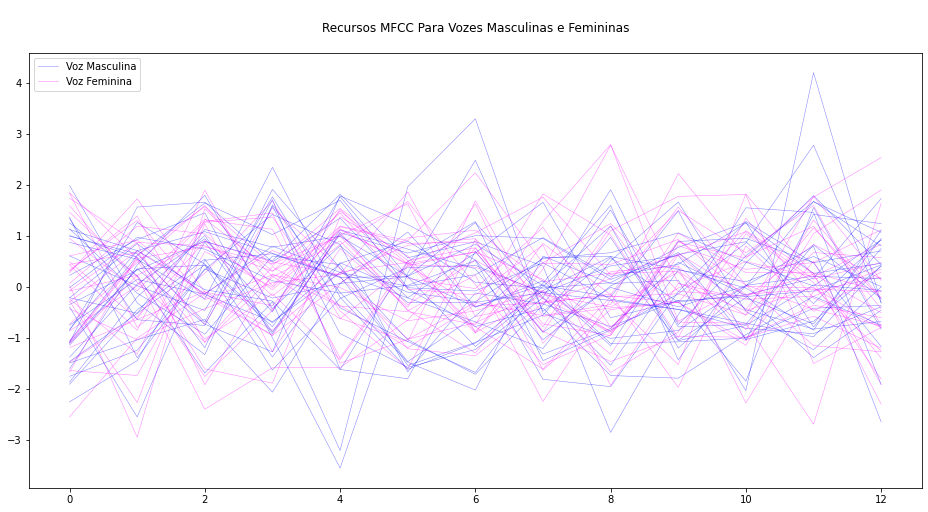

In [25]:
# Plot de visualização dos recursos como sinais

# Área de plotagem
plt.figure(figsize = (16,8))

# Loop pelos recursos
for i in range(1, 30000, 1000):
    plt.plot(recursos_m[i], c = 'blue', linewidth = 0.5, alpha = 0.5)
    plt.plot(recursos_f[i], c = 'magenta', linewidth = 0.5, alpha = 0.5)

# Plot    
plt.plot(recursos_m[i+1], c = 'blue', label = "Voz Masculina", linewidth = 0.5, alpha = 0.5)
plt.plot(recursos_f[i+1], c = 'magenta', label = "Voz Feminina", linewidth = 0.5, alpha = 0.5)
plt.legend()
plt.title("\nRecursos MFCC Para Vozes Masculinas e Femininas\n")
plt.show()

## Construção e Treinamento dos Modelos

Para criar um sistema de reconhecimento de gênero a partir dos recursos extraídos acima, precisamos modelar ambos os sexos. Empregaremos modelos GMM (Gaussian Mixture Model) para esta tarefa.

Um modelo de mistura gaussiano é um modelo probabilístico de agrupamento (Clustering) para representar a presença de subpopulações dentro de uma população geral. A ideia de treinar um GMM é aproximar a distribuição de probabilidade de uma classe por uma combinação linear de distribuições / grupos Gaussianos 'k', também chamados de componentes do GMM. 

![title](imagens/gmm.png)

O pacote sklearn.mixture da Linguagem Python é usado para treinar um modelo GMM a partir da matriz que contém os recursos do MFCC. O objeto GMM exige que o número de componentes n_components seja ajustado nos dados, além do número de iterações max_iter a serem executadas para estimar os parâmetros desses n componentes, bem como o tipo de covariância a ser assumida entre os recursos e o número de vezes n_init para a inicialização dos componentes. A inicialização que deu os melhores resultados é mantida. A função fit() estima os parâmetros do modelo usando o algoritmo Expectation Maximization.

https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

Modelo para vozes masculinas.

In [26]:
# Cria o modelo
modelo_GMM_m = GMM(n_components = 8, max_iter = 200, covariance_type = 'diag', n_init = 3)

In [27]:
# Treina o modelo
modelo_GMM_m.fit(recursos_m)

GaussianMixture(covariance_type='diag', max_iter=200, n_components=8, n_init=3)

In [28]:
# Salvamos o modelo em disco
cPickle.dump(modelo_GMM_m, open("modelos/" + "modelo_GMM_m", 'wb'))

Modelo para vozes femininas.

In [29]:
# Cria o modelo
modelo_GMM_f = GMM(n_components = 8, max_iter = 200, covariance_type = 'diag', n_init = 3)

In [30]:
# Treina o modelo
modelo_GMM_f.fit(recursos_f)

GaussianMixture(covariance_type='diag', max_iter=200, n_components=8, n_init=3)

In [31]:
# Salvamos o modelo em disco
cPickle.dump(modelo_GMM_f, open("modelos/" + "modelo_GMM_f", 'wb'))

## Avaliando o Modelo com Dados de Teste

### Carregando os Dados Para Teste

In [32]:
# Caminho para os dados de teste
teste_voz_m = "dados/teste/AudioSet/male_clips"
teste_voz_f = "dados/teste/AudioSet/female_clips"

In [33]:
# Cria lista de arquivos       
lista_teste_m = [os.path.join(teste_voz_m, f) for f in os.listdir(teste_voz_m) if f.endswith('.wav')] 
lista_teste_f = [os.path.join(teste_voz_f, f) for f in os.listdir(teste_voz_f) if f.endswith('.wav')] 

In [34]:
# Visualiza alguns arquivos em teste
lista_teste_m[1:5]

['dados/teste/AudioSet/male_clips/1-wdrZMz8g8.wav',
 'dados/teste/AudioSet/male_clips/1xmxlZvjtq8.wav',
 'dados/teste/AudioSet/male_clips/2tnfiLIfRD8.wav',
 'dados/teste/AudioSet/male_clips/0qbhN2wWeiQ.wav']

In [35]:
# Visualiza alguns arquivos em teste
lista_teste_f[1:5]

['dados/teste/AudioSet/female_clips/2vN77gHhWAA.wav',
 'dados/teste/AudioSet/female_clips/-Hr1Lhntf3M.wav',
 'dados/teste/AudioSet/female_clips/038H9i5KHlM.wav',
 'dados/teste/AudioSet/female_clips/-jjWi-og5Qs.wav']

### Extração de Recursos

In [36]:
# Criamos arrays para receber os recursos extraídos
recursos_teste_m = np.asarray(())
recursos_teste_f = np.asarray(())

In [37]:
# Loop pela lista de arquivos para extração de recursos de vozes masculinas
for arq_teste_m in lista_teste_m:
    
    # Leitura do arquivo de áudio em disco
    sr, audio = read(arq_teste_m)
    
    # Vetor de recursos extraídos
    vetor_recursos = extrai_MFCC(sr, audio)
    
    # Verifica o tamanho do array de recursos criado na célula anterior
    # Se for zero, inclui o primeiro vetor de recursos
    # Se for maior que zero, faz o append
    if recursos_teste_m.size == 0:
        recursos_teste_m = vetor_recursos
    else:
        recursos_teste_m = np.vstack((recursos_teste_m, vetor_recursos))

In [38]:
# Loop pela lista de arquivos para extração de recursos de vozes femininas
for arq_teste_f in lista_teste_f:
    
    # Leitura do arquivo de áudio em disco
    sr, audio = read(arq_teste_f)
    
    # Vetor de recursos extraídos
    vetor_recursos = extrai_MFCC(sr, audio)
    
    # Verifica o tamanho do array de recursos criado na célula anterior
    # Se for zero, inclui o primeiro vetor de recursos
    # Se for maior que zero, faz o append
    if recursos_teste_f.size == 0:
        recursos_teste_f = vetor_recursos
    else:
        recursos_teste_f = np.vstack((recursos_teste_f, vetor_recursos))

### Teste do Modelo

In [39]:
# Lista para o resultado
output_m = []

In [40]:
# Loop pelos recursos de vozes masculinas e teste dos 2 modelos
for f in recursos_teste_m:

    # Aplica o modelo de vozes masculinas
    log_likelihood_male = np.array(modelo_GMM_m.score([f])).sum()
    
    # Aplica o modelo de vozes femininas
    log_likelihood_female = np.array(modelo_GMM_f.score([f])).sum()
    
    # Verifica qual probabilidade é a maior e grava a classe final como resultado
    if log_likelihood_male > log_likelihood_female:
        output_m.append(0)
    else:
        output_m.append(1)

In [41]:
# Cálculo da acurácia
acc_m = (1 - sum(output_m) / len(output_m))
print("Acurácia do Modelo de Reconhecimento de Vozes Masculinas: ", acc_m)

Acurácia do Modelo de Reconhecimento de Vozes Masculinas:  0.5428585599553246


In [42]:
# Lista para o resultado
output_f = []

In [43]:
# Loop pelos recursos de vozes femininas e teste dos 2 modelos
for f in recursos_teste_f:
    
    # Aplica o modelo de vozes masculinas
    log_likelihood_m = np.array(modelo_GMM_m.score([f])).sum()
    
    # Aplica o modelo de vozes femininas
    log_likelihood_f = np.array(modelo_GMM_f.score([f])).sum()
    
    # Verifica qual probabilidade é a maior e grava a classe final como resultado
    if log_likelihood_m > log_likelihood_f:
        output_f.append(0)
    else:
        output_f.append(1)

In [44]:
# Cálculo da acurácia
acc_f = (1 - sum(output_f) / len(output_f))
print("Acurácia do Modelo de Reconhecimento de Vozes Femininas: ", acc_f)

Acurácia do Modelo de Reconhecimento de Vozes Femininas:  0.33064879294754246


## Treinamento com o Conjunto de Dados Completo

Vamos criar modelos com maior precisão e usar todos os arquivos disponíveis para treinamento. Usaremos os 2 modelos para reconhecimento de voz em tempo real em a nossa aplicação.

In [45]:
# Função para extrair todos os recursos de todos os arquivos disponíveis
def extrai_recursos_ALL(source):
    
    # Lista arquivos
    lista_arquivos = [os.path.join(source, f) for f in os.listdir(source) if f.endswith('.wav')] 
    
    # Lista de recursos
    recursos = []
    
    # Loop pela lista de arquivos
    for arq in lista_arquivos:
        
        # Leitura do arquivo
        sr, audio = read(arq)
        
        # Extração dos recursos
        vetor_recursos = extrai_MFCC(sr, audio)
        
        # Verifica se insere ou faz o append
        if len(recursos) == 0:
            recursos = vetor_recursos
        else:
            recursos = np.vstack((recursos, vetor_recursos))

    return recursos

Agora treinamos os modelos com todos os arquivos do dataset AudioSet.

Modelo de vozes masculinas:

In [46]:
# Extrai os recursos de vozes masculinas
source_m = "dados/teste/AudioSet/male_clips"
recursos_m = extrai_recursos_ALL(source_m)

# Treina o modelo de vozes masculinas
modelo_GMM_m_final = GMM(n_components = 8, max_iter = 200, covariance_type = 'diag', n_init = 3)
modelo_GMM_m_final.fit(recursos_m)

GaussianMixture(covariance_type='diag', max_iter=200, n_components=8, n_init=3)

In [47]:
# Salvamos o modelo em disco
cPickle.dump(modelo_GMM_m_final, open("modelos/" + "modelo_GMM_m_final.gmm", "wb" ))

Modelo de vozes femininas:

In [48]:
# Extrai os recursos de vozes femininas
source_f = "dados/teste/AudioSet/female_clips"
recursos_f = extrai_recursos_ALL(source_f)

# Treina o modelo de vozes femininas
modelo_GMM_f_final = GMM(n_components = 8, max_iter = 200, covariance_type = 'diag', n_init = 3)
modelo_GMM_f_final.fit(recursos_f)

GaussianMixture(covariance_type='diag', max_iter=200, n_components=8, n_init=3)

In [49]:
# Salvamos o modelo em disco
cPickle.dump(modelo_GMM_m_final, open("modelos/" + "modelo_GMM_f_final.gmm", "wb" ))

## Visualização dos Recursos MFCC

In [50]:
len(recursos_m)

544372

In [51]:
len(recursos_f)

555154

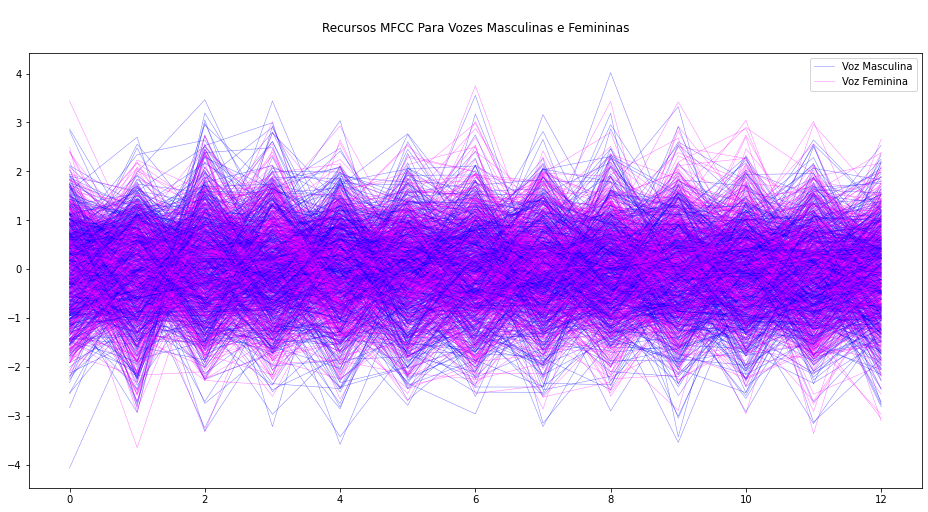

In [52]:
# Plot de visualização dos recursos como sinais

# Área de plotagem
plt.figure(figsize = (16,8))

# Loop pelos recursos
for i in range(1, 540000, 1000):
    plt.plot(recursos_m[i], c = 'blue', linewidth = 0.5, alpha = 0.5)
    plt.plot(recursos_f[i], c = 'magenta', linewidth = 0.5, alpha = 0.5)

# Plot    
plt.plot(recursos_m[i+1], c = 'blue', label = "Voz Masculina", linewidth = 0.5, alpha = 0.5)
plt.plot(recursos_f[i+1], c = 'magenta', label = "Voz Feminina", linewidth = 0.5, alpha = 0.5)
plt.legend()
plt.title("\nRecursos MFCC Para Vozes Masculinas e Femininas\n")
plt.show()

## Reconhecimento de Voz em Tempo Real

In [53]:
# Função para gravar o áudio e fazer o reconhecimento em tempoo real
def reconhece_voz_tempo_real(sr = 16000, channels = 1, duration = 3, filename = 'temp/voz.wav'):
    
    # Inicia a gravação da voz
    audio_gravado = sd.rec(int(duration * sr), samplerate = sr, channels = channels).reshape(-1)
    
    # Aguarda a conclusão
    sd.wait()
    
    # Extrai os recursos
    recursos = extrai_MFCC(sr, audio_gravado)
    
    # Inicializa a variável de scores
    scores = None

    # Aplica os modelos
    log_likelihood_m = np.array(modelo_GMM_m_final.score(recursos)).sum()
    log_likelihood_f = np.array(modelo_GMM_f_final.score(recursos)).sum()

    # Verifica qual moodelo obteve a maior probabilidade e faz a previsão final
    if log_likelihood_m >= log_likelihood_f:
        
        return("Voz Masculina")
    else:
        return("Voz Feminina")

In [55]:
# Executa a função
reconhece_voz_tempo_real()

'Voz Masculina'

# Fim